# Machine Learning and Statistics for Physicists

Material for a [UC Irvine](https://uci.edu/) course offered by the [Department of Physics and Astronomy](https://www.physics.uci.edu/).

Content is maintained on [github](github.com/dkirkby/MachineLearningStatistics) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

[Table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
from scipy.optimize import minimize

In [3]:
import scipy.stats

In [4]:
import time

In [5]:
from mls import plot_rosenbrock, plot_posterior

## Optimization

Optimization solves the following problem: given a scalar-valued function $f(\mathbf{x})$ defined in the multidimensional space of $\mathbf{x}$, find the value $\mathbf{x}=\mathbf{x}^\ast$ where $f(\mathbf{x})$ is minimized, or, in more formal language:
$$
\mathbf{x}^\ast = \underset{\mathbf{x}}{\mathrm{argmin}}\, f(\mathbf{x})
$$
This statement of the problem is more general that it first appears, since:
 - Minimizing $-f$ is equivalent to maximizing $f$.
 - A vector-valued function can also be optimized by defining a suitable norm, $f = |\vec{f}|$.
 - Constraints on the allowed values of $\mathbf{x}$ can be encoded in $f$ by having it return $\infty$ in illegal regions.
 
This is conceptually a straightforward problem, but efficient numerical methods are challenging, especially in high dimensions.

The simplest method is an exhaustive grid search. In 1D, this boils down to making a plot and reading off the lowest value.  For example (note the useful [np.argmin](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmin.html)):

In [6]:
def f(x):
    return x ** 2 - 10 * np.exp(-10000 * (x - np.pi) ** 2)

min f(x) at x = 0.0


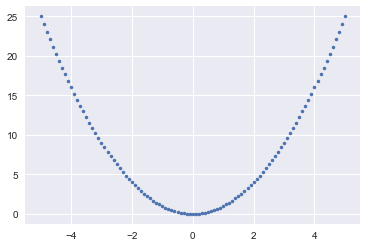

In [7]:
x = np.linspace(-5, +5, 101)
plt.plot(x, f(x), '.')
print('min f(x) at x =', x[np.argmin(f(x))])

**EXERCISE:** Study the example above and explain why it fails to find the true minimum of $f(x)$. Make a different plot that does find the true minimum.

A search using a grid with spacing $\Delta x$ can completely miss features narrower than $\Delta x$, so is only reliable when you have some prior knowledge that your $f(x)$ does not have features narrower than some limit.

In [ ]:
x = np.linspace(3.1, 3.2, 100)
plt.plot(x, f(x), '.');

The main computational cost of optimization is usually the evaluation of $f$, so an important metric for any optimizer is the number of times it evaluates $f$.

In $D$ dimensions, a grid search requires $f$ to be evaluated at $n^D$ different locations, which becomes prohibitive for large $D$. Fortunately, there are much better methods when $f$ satisfies two conditions:
 - It is reasonably smooth, so that local derivatives reliably point "downhill".
 - It has a single global minimum.

The general approach of these methods is to simulate a ball moving downhill until it can go no further.

The first condition allows us to calculate the gradient $\nabla f(\mathbf{x})$ at the ball's current location, $\mathbf{x}_n$, and then move in the downhill direction:
$$
\mathbf{x}_{n+1} = \mathbf{x}_n - \eta \nabla f(\mathbf{x}_n) \; .
$$
This **gradient descent** method uses a parameter $\eta$ to control the size of each step: the ball might overshoot if this is too large, but too small values make unnecessary evaluations. In machine learning contexts, $\eta$ is often referred to as the **learning rate**. There are different strategies for adjusting $\eta$ on the fly, but no universal best compromise between robustness and efficiency.

The second condition is necessary to avoid getting trapped in the false minimum at $x=0$ in the example above. We often cannot guarantee the second condition but all is not lost: the first condition still allows us to reliably find a *local minimum*, but we can never know if it is also the global minimum. A practical workaround is to simulate many balls starting from different locations and hope that at least one of them falls into the global minimum.

[Convex functions](https://en.wikipedia.org/wiki/Convex_function) are special since they are guaranteed to meet the second condition. We have already seen that the KL divergence is convex and discussed [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen's_inequality) which applies to convex functions.  Convex functions are extremely important in optimization but rare in the wild: unless you know that your function has a single global minimum, you should generally assume that it has many local minima, especially in many dimensions.

## Derivatives

Derivatives of $f(\mathbf{x})$ are very useful for optimization and can be calculated several ways. The first method is to work out the derivatives by hand and code them up, for example:

In [8]:
def f(x):
    return np.cos(np.exp(x)) / x ** 2

In [9]:
def fp(x):
    return -2 * np.cos(np.exp(x)) / x ** 3 - np.exp(x) * np.sin(np.exp(x)) / x ** 2

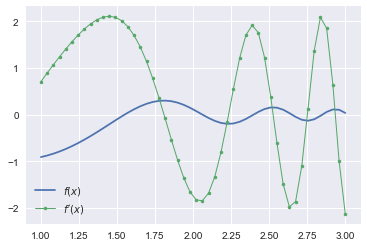

In [10]:
x = np.linspace(1, 3, 50)
plt.plot(x, f(x), label='$f(x)$')
plt.plot(x, fp(x), '.-', lw=1, label='$f\'(x)$')
plt.legend();

Derivatives can also be calculated numerically using [finite difference equations](https://en.wikipedia.org/wiki/Finite_difference) such as:
$$
\frac{\partial}{\partial x_i} f(\mathbf{x}) = 
\frac{f(\mathbf{x} + \delta \mathbf{e}_i) - f(\mathbf{x} - \delta \mathbf{e}_i)}{2\delta}
+ {\cal O}(\delta^2) \; .
$$
For example, with [np.gradient](https://docs.scipy.org/doc/numpy/reference/generated/numpy.gradient.html):

In [11]:
fp_numeric = np.gradient(f(x), x)

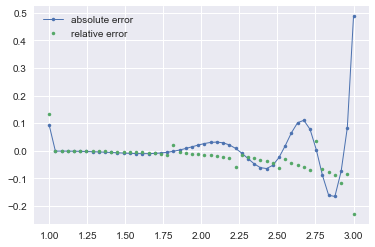

In [12]:
plt.plot(x, (fp_numeric - fp(x)), '.-', lw=1, label='absolute error')
plt.plot(x, (fp_numeric - fp(x)) / fp(x), '.', label='relative error')
plt.legend();

There is also a third hybrid approach that has proven very useful in machine learning, especially for training deep neural networks: [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation). This requires that a small set of primitive functions (sin, cos, exp, log, ...) are handled analytically, and then composition of these primitives is handled by applying the rules of differentiation (chain rule, product rule, etc) directly to the code that evaluates `f(x)`.

For example, using the [autograd package](https://github.com/HIPS/autograd/blob/master/docs/tutorial.md):

In [13]:
from autograd import grad, elementwise_grad
import autograd.numpy as anp

In [14]:
def f_auto(x):
    return anp.cos(anp.exp(x)) / x ** 2

In [15]:
fp_auto = elementwise_grad(f_auto)

In this case, the automatic derivates are identical to the exact results up to round-off errors (note the `1e-16` multiplier on the y axis):

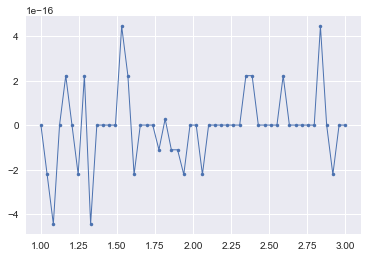

In [16]:
plt.plot(x, fp_auto(x) - fp(x), '.-', lw=1);

Note that automatic differentiation cannot perform miracles.  For example, the following implementation of
$$
\mathrm{sinc}(x) \equiv \frac{\sin{x}}{x}
$$
cannot be evaluated at $x = 0$, so neither can its automatic derivative:

In [ ]:
def sinc(x):
    return anp.sin(x) / x

In [ ]:
sinc(0.)

In [ ]:
grad(sinc)(0.)

**EXERCISE:** Modify the implementation of `sinc` above to cure both of these problems. Hint: `grad` can automatically differentiate through control flow structures (`if`, `while`, etc).

The simplest fix is to return 1 whenever x is zero:

In [ ]:
def sinc(x):
    return anp.sin(x) / x if x != 0 else 1.

In [ ]:
assert sinc(0.) == 1

This gives the correct derivative but still generates a warning because x=0 is treated as an isolated point:

In [ ]:
grad(sinc)(0.)

A better solution is to use a Taylor expansion for $|x| \lt \epsilon$:

In [ ]:
def sinc(x):
    return anp.sin(x) / x if np.abs(x) > 0.001 else 1 - x ** 2 / 6

In [ ]:
assert sinc(0.) == 1

In [ ]:
assert grad(sinc)(0.) == 0

In [ ]:
# Add your solution here...

We will see automatic differentiation again soon in the context of [tensorflow](https://www.tensorflow.org/).

## Optimization in Machine Learning

Most ML algorithms involve some sort of optimization (although MCMC sampling is an important exception). For example, the [K-means clustering algorithm](http://scikit-learn.org/stable/modules/clustering.html#k-means) minimizes
$$
\sum_{i=1}^n\, \sum_{c_j = i}\, \left| x_j - \mu_i\right|^2
$$
where $c_j = 1$ if sample $j$ is assigned to cluster $i$ or otherwise $c_j = 0$, and
$$
\mu_i = \sum_{c_j = i}\, x_j
$$
is the mean of samples assigned to cluster $i$.

Optimization is also useful in Bayesian inference. In particular, it allows us to locate the most probable point in the parameter space, known as the **maximum a-posteriori (MAP) point estimate**:
$$
MAP \equiv \underset{\mathbf{\theta}}{\mathrm{argmin}}\, [-\log P(\theta\mid D)] \; .
$$
You can also locate the point that is most probable according to just your likelihood, known as the **maximum likelihood (ML) point estimate**:
$$
ML \equiv \underset{\mathbf{\theta}}{\mathrm{argmin}}\, [-\log P(D\mid \theta)] \; .
$$
Frequentists who do not believe in priors generally focuses on ML, but MAP is the fundamental point estimate in Bayesian inference. Note that the log above reduces round-off errors when the optimizer needs to explore a large dynamic range (as is often true) and the minus sign converts a maximum probability into a minimum function value.

Note that a point estimate is not very useful on its own since it provides no information on what range of $\theta$ is consistent with the data, otherwise known as the parameter uncertainty!  Point estimates are still useful, however, to provide a good starting point for MCMC chains or when followed by an exploration of the surrounding posterior to estimate uncertainties.

Variational inference is another important application of optimization, where it allows us to find the "closest" approximating PDF $q(\theta; \lambda)$ to the true posterior PDF $P(\theta\mid D)$ by optimizing with respect to variables $\lambda$ that explore the approximating family $q$:
$$
VI \equiv \underset{\mathbf{\lambda}}{\mathrm{argmin}}\,
[-\mathrm{ELBO}(q(\theta; \lambda) \parallel P(\theta\mid D)] \; .
$$

Finally, training a neural network is essentially an optimization task, as we will shall see soon.

## Optimization Methods

To compare different methods, we will use the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function), which is smooth but sufficiently non-linear to be a good challenge:
$$
f(x_0, x_1) = (1 - x_0)^2 + 100 (x_1 - x_0 ^2)^2 \; .
$$

Most implementations need a function that takes all components of $\mathbf{x}$ in a single array argument:

In [17]:
def rosenbrock(x):
    x0, x1 = x
    return (1 - x0) ** 2 + 100.0 * (x1 - x0 ** 2) ** 2

This function has a curved valley with a shallow minimum at $(x,y) = (1,1)$ and steeply rising sides:

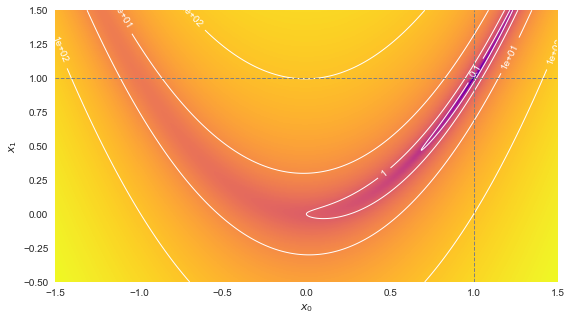

In [18]:
plot_rosenbrock();

**EXERCISE:** Is the Rosenbrock function convex?  In other words, does a straight line between any two points on its surface always lie above the surface?

The Rosenbrock function is not convex. Take, for example, the line $x_1 = 1$ shown above:

In [ ]:
x0 = np.linspace(-1.5, 1.5, 100)
plt.plot(x0, rosenbrock([x0, 1.0]));

The [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) module implements a suite of standard general-purpose algorithms that are accessible via its [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function. For example, to find the minimum of the Rosenbrock function starting from $(-1,0)$ and using the robust [Nelder-Mead](https://en.wikipedia.org/wiki/Nelder-Mead_method) algorithm, which does not use derivatives:

In [19]:
opt = minimize(rosenbrock, [-1, 0], method='Nelder-Mead', tol=1e-4)
print(opt.message, opt.x)

Optimization terminated successfully. [ 1.00000935  1.00001571]


The `tol` (tolerance) parameter roughly corresponds to the desired accuracy in each coordinate.

Most methods accept an optional `jac` (for Jacobian) argument to pass a function that calculates partial derivatives along each coordinate.  For our Rosenbrock example, we can construct a suitable function using automatic differentiation:

In [20]:
rosenbrock_grad = grad(rosenbrock)

Here is an example of optimizing using derivatives with the [conjugate-gradient (CG) method](https://en.wikipedia.org/wiki/Conjugate_gradient_method):

In [21]:
opt = minimize(rosenbrock, [-1, 0], method='CG', jac=rosenbrock_grad, tol=1e-4)
print(opt.message, opt.x)

Optimization terminated successfully. [ 0.99999634  0.99999279]


A method using derivatives will generally require fewer calls to $f(\mathbf{x})$ but might still be slower due to the additional partial derivative evaluations. Some (but not all) methods that use partial derivatives will estimate them numerically, with additional calls to $f(\mathbf{x})$, if a `jac` function is not provided.

The function below uses wrappers to track and display the optimizer's progress, and also displays the running time:

In [22]:
def optimize_rosenbrock(method, use_grad=False, x0=-1, y0=0, tol=1e-4):
    
    all_calls = []
    def rosenbrock_wrapped(x):
        all_calls.append(x)
        return rosenbrock(x)
    
    path = [(x0,y0)]
    def track(x):
        path.append(x)

    jac = rosenbrock_grad if use_grad else False
    
    start = time.time()
    opt = minimize(rosenbrock_wrapped, [x0, y0], method=method, jac=jac, tol=tol, callback=track)
    stop = time.time()
    
    assert opt.nfev == len(all_calls)
    njev = opt.get('njev', 0)    
    print('Error is ({:+.2g},{:+.2g}) after {} iterations making {}+{} calls in {:.2f} ms.'
          .format(*(opt.x - np.ones(2)), opt.nit, opt.nfev, njev, 1e3 * (stop - start)))    

    xrange, yrange = plot_rosenbrock(path=path, all_calls=all_calls)

Black points show the progress after each iteration of the optimizer and cyan points show additional auxiliary calls to $f(\mathbf{x})$:

Error is (+9.4e-06,+1.6e-05) after 83 iterations making 153+0 calls in 6.88 ms.


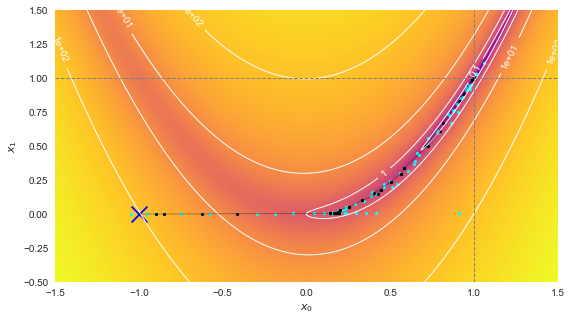

In [23]:
optimize_rosenbrock(method='Nelder-Mead', use_grad=False)

In this example, we found the true minimum with an error below $10^{-4}$ in each coordinate (as requested) using about 150 calls to evaluate $f(\mathbf{x})$, but an exhaustive grid search would have required more than $10^{8}$ calls to achieve comparable accuracy!

The [conjugate-gradient (CG) method](https://en.wikipedia.org/wiki/Conjugate_gradient_method) uses gradient derivatives to always move downhill:

In [ ]:
optimize_rosenbrock(method='CG', use_grad=True)

CG can follow essentially the same path using numerical estimates of the gradient derivatives, which requires more evaluations of $f(\mathbf{x})$ but is still faster in this case:

In [ ]:
optimize_rosenbrock(method='CG', use_grad=False)

[Newton's CG method](https://en.wikipedia.org/wiki/Newton's_method_in_optimization) requires analytic derivatives and makes heavy use of them to measure and exploit the curvature of the local surface:

In [ ]:
optimize_rosenbrock(method='Newton-CG', use_grad=True)

[Powell's method](https://en.wikipedia.org/wiki/Powell's_method) does not use derivatives but requires many auxiliary evaluations of $f(\mathbf{x})$:

In [ ]:
optimize_rosenbrock(method='Powell', use_grad=False)

Finally, the [BFGS method](https://en.wikipedia.org/wiki/Broyden-Fletcher-Goldfarb-Shanno_algorithm) is a good all-around default choice, with or without derivatives:

In [ ]:
optimize_rosenbrock(method='BFGS', use_grad=False)

The choice of initial starting point can have a big effect on the optimization cost, as measured by the number of calls to evaluate $f(\mathbf{x})$.  For example, compare:

In [ ]:
optimize_rosenbrock(method='BFGS', use_grad=False, x0=1.15, y0=0.5)

In [ ]:
optimize_rosenbrock(method='BFGS', use_grad=False, x0=1.20, y0=0.5)

**EXERCISE:** Predict which initial starting points would require the most calls to evaluate $f(\mathbf{x})$ for the Rosenbrock function?  Does your answer depend on the optimization method?

The cost can be very sensitive to the initial conditions in ways that are difficult to predict. Different methods will have different sensitivities but, generally, the slower more robust methods should be less sensitive with more predictable costs.

The function below maps the cost as a function of the starting point:

In [ ]:
def cost_map(method, tol=1e-4, ngrid=50):
    xrange, yrange = plot_rosenbrock(shaded=False)
    x0_vec = np.linspace(*xrange, ngrid)
    y0_vec = np.linspace(*yrange, ngrid)
    cost = np.empty((ngrid, ngrid))
    for i, x0 in enumerate(x0_vec):
        for j, y0 in enumerate(y0_vec):
            opt = minimize(rosenbrock, [x0, y0], method=method, tol=tol)
            cost[j, i] = opt.nfev
    plt.imshow(cost, origin='lower', extent=[*xrange, *yrange],
               interpolation='none', cmap='magma', aspect='auto', vmin=0, vmax=250)
    plt.colorbar().set_label('Number of calls')

The BFGS "racehorse" exhibits some surprising discontinuities in its cost function:

In [ ]:
cost_map('BFGS')

The Nelder-Mead "ox", in contrast, is more expensive overall (both plots use the same color scale), but has a smoother cost function (but there are still some isolated "hot spots"):

In [ ]:
cost_map('Nelder-Mead')

In [ ]:
# Add your solution here...

When the function you are optimizing is derived from a likelihood (which includes a chi-squared likelihood for binned data), there are some other optimization packages that you might find useful:
- [lmfit](http://cars9.uchicago.edu/software/python/lmfit/): a more user-friendly front-end to `scipy.optimize`.
- [minuit](https://en.wikipedia.org/wiki/MINUIT): a favorite in the particle physics community that is generally more robust and provides tools to estimate (frequentist) parameter uncertainties.

## Stochastic Optimization

In machine-learning applications, the function being optimized often involves an inner loop over data samples. For example, in Bayesian inference, this enters via the likelihood,
$$
\log P(D\mid \theta) = \sum_i \log P(x_i\mid \theta) \; ,
$$
where the $x_i$ are the individual data samples.  With a large number of samples, this iteration can be prohibitively slow, but **stochastic optimization** provides a neat solution.

For example, generate some data from a Gaussian likelihood:

In [24]:
D = scipy.stats.norm.rvs(loc=0, scale=1, size=200, random_state=123)

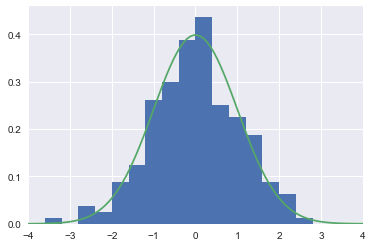

In [25]:
x = np.linspace(-4, +4, 100)
plt.hist(D, range=(x[0], x[-1]), bins=20, normed=True)
plt.plot(x, scipy.stats.norm.pdf(x,loc=0,scale=1))
plt.xlim(x[0], x[-1]);

The corresponding negative-log-likelihood (NLL) function of the `loc` and `scale` parameters is then (we write it out explicitly using autograd numpy calls so we can perform automatic differentiation later):

In [26]:
def NLL(theta, D):
    mu, sigma = theta
    return anp.sum(0.5 * (D - mu) ** 2 / sigma ** 2 + 0.5 * anp.log(2 * anp.pi) + anp.log(sigma))

Add (un-normalized) flat priors on $\mu$ and $\log\sigma$ (these are the "natural" un-informative priors for additive and multiplicative constants, respectively):

In [27]:
def NLP(theta):
    mu, sigma = theta
    return -anp.log(sigma) if sigma > 0 else -anp.inf

In [28]:
def NLpost(theta, D):
    return NLL(theta, D) + NLP(theta)

The function we want optimize is then the negative-log-posterior:
$$
f(\theta) = -\log P(\theta\mid D) \; .
$$

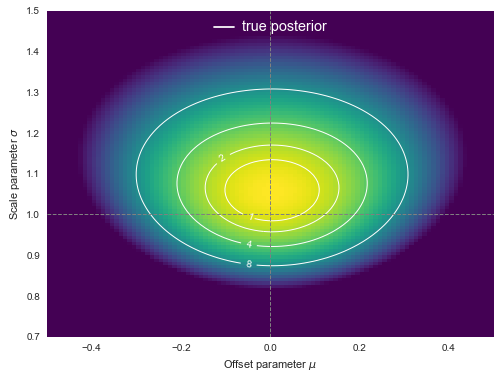

In [29]:
plot_posterior(D);

**DISCUSS:** Why is $f(\theta)$ not centered at the true value $(\mu, \sigma) = (0, 1)$?

There are two reasons:
 - Statistical fluctuations in the randomly generated data will generally offset the maximum likelihood contours. The expected size of this shift is referred to as the **statistical uncertainty**.
 - The priors favor a lower value of $\sigma$, which pulls these contours down. The size of this shift will be negligible for an informative experiment, and significant when there is insufficient data.
 
---

**DISCUSS:** How do you expect the plot above to change if only half of the data is used?  How would using the first or second half change the plot?

Using half of the data will increase the statistical uncertainty, resulting in larger contours. Independent subsets of the data will have uncorrelated shifts due to the statistical uncertainty.

In [ ]:
plot_post(D[:100]);

In [ ]:
plot_post(D[100:]);

We will optimize this function using a simple gradient descent with a fixed learning rate $\eta$:
$$
\mathbf{\theta}_{n+1} = \mathbf{\theta}_n - \frac{\eta}{N} \nabla f(\mathbf{\theta}_n) \; ,
$$
where $N$ is the number of samples in $D$.

Use automatic differentiation to calculate the gradient of $f(\theta)$ with respect to the components of $\theta$ ($\mu$ and $\sigma$):

In [30]:
NLpost_grad = grad(NLpost)

In [31]:
def step(theta, D, eta):
    return theta - eta * NLpost_grad(theta, D) / len(D)

In [32]:
def GradientDescent(mu0, sigma0, eta, n_steps):
    path = [np.array([mu0, sigma0])]
    for i in range(n_steps):
        path.append(step(path[-1], D, eta))
    return path

The resulting path rolls "downhill", just as we would expect.  Note that a constant learning rate does not translate to a constant step size. (Why?)

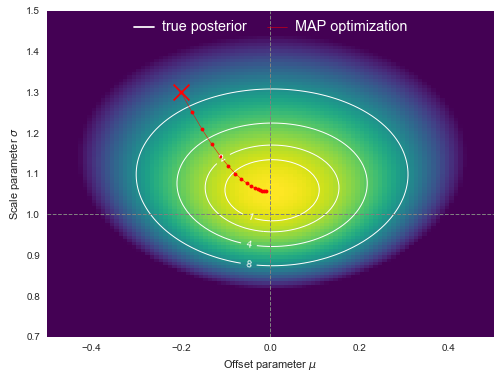

In [33]:
plot_posterior(D, path=GradientDescent(mu0=-0.2, sigma0=1.3, eta=0.2, n_steps=15))

The **stochastic gradient** method uses a random subset of the data, called a **minibatch**, during each iteration. Only small changes to `StochasticGradient` above are required to implement this scheme (and no changes are needed to `step`):
 - Add a `seed` parameter for reproducible random subsets.
 - Specify the minibatch size `n_minibatch` and use [np.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html) to select it during each iteration.
 - Reduce the learning rate after each iteration by `eta_factor`.

In [ ]:
def StochasticGradientDescent(mu0, sigma0, eta, n_minibatch, eta_factor=0.95, seed=123, n_steps=15):
    gen = np.random.RandomState(seed=seed)
    path = [np.array([mu0, sigma0])]
    for i in range(n_steps):
        minibatch = gen.choice(D, n_minibatch, replace=False)
        path.append(step(path[-1], minibatch, eta))
        eta *= eta_factor
    return path

Using half of the data on each iteration (`n_minibatch=100`) means that the gradient is calculated from a different surface each time, with larger contours and random shifts.  We have effectively added some noise to the gradient, but it still converges reasonably well:

In [ ]:
plot_posterior(D, path=StochasticGradientDescent(
    mu0=-0.2, sigma0=1.3, eta=0.2, n_minibatch=100, n_steps=100))

Note that the learning-rate decay is essential to prevent the optimizer wandering aimlessly once it gets close to the minimum:

In [ ]:
plot_posterior(D, path=StochasticGradientDescent(
    mu0=-0.2, sigma0=1.3, eta=0.2, eta_factor=1, n_minibatch=100, n_steps=100))

Remarkably, [stochastic gradient descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) works with even smaller minibatches, with some careful tuning of the hyperparameters, although it might converge to a slightly different minimum. For example:

In [ ]:
plot_posterior(D, path=StochasticGradientDescent(
    mu0=-0.2, sigma0=1.3, eta=0.15, eta_factor=0.97, n_minibatch=20, n_steps=75))

Comparing this example with our `GradientDescent` above, we find that the number of steps has increased 5x while the amount of data used during each iteration has decreased 10x, so roughly a net factor of 2 improvement in overall performance.

SGD has been used very successfully in training deep neural networks, where it solves two problems:
 - Deep learning requires massive training datasets which are then slow to optimize, so any gains in performance are welcome.
 - The noise introduced by SGD helps prevent "over-learning" of the training data and improves the resulting ability to generalize to data outside the training set. We will revisit this theme soon.